In [2]:
import numpy as np
import pprint
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, make_scorer, precision_score, recall_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import advertools as adv
pp = pprint.PrettyPrinter(indent=4, sort_dicts=False)


In [3]:
train_data = pd.read_csv("corpus/nolang_dif/train_data.csv")
print(train_data.head())


test_data = pd.read_csv("corpus/nolang_dif/test_data.csv")
print(test_data.head())


   index language                                               text    label
0      0       da  Dette er et fremragende initiativ, og jeg støt...  Ireland
1      1       da  Hr. formand, jeg er sikker på, at alle her er ...  Ireland
2      2       da  Hr. formand, folk på den nordlige halvkugle tr...  England
3      3       da  Hr. formand, med forbehold af nogle få ændring...  England
4      4       da  Hr. formand, jeg må protestere mod den lemfæld...  England
   index                                               text language
0      0  Hr. formand, selv om vi i høj grad sympatisere...       da
1      1  Quiero dejar constancia de mi apoyo a este inf...       es
2      2  – El comercio ilegal de riñones humanos se ha ...       es
3      3  Signor Presidente, per introdurre una nota di ...       it
4      4  Jeg stemte for meddelelsen af decharge til fæl...       da


In [4]:
train_data = train_data.drop("language", axis=1)
train_data = train_data[pd.notnull(train_data["text"])]
train_data["category_id"] = train_data["label"].astype("category")
train_data["category_id"] = train_data["category_id"].cat.codes

train_data.head()

category_id_df = train_data[["label", "category_id"]].drop_duplicates().sort_values("category_id")
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[["category_id", "label"]].values)


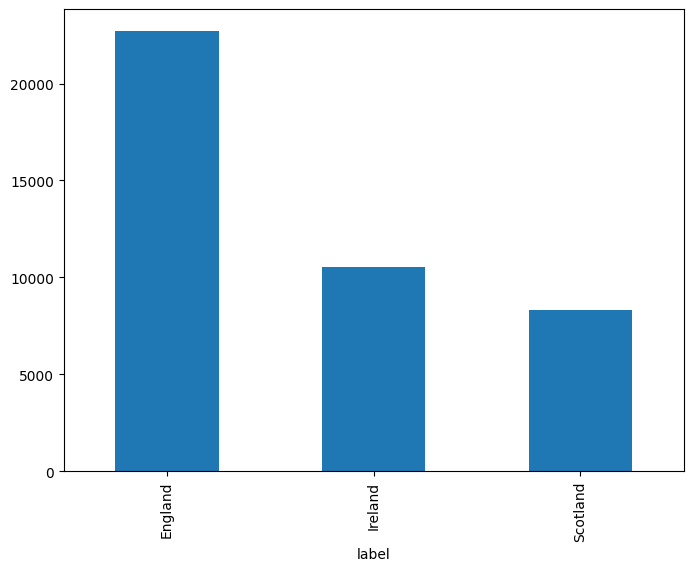

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
train_data.groupby("label").text.count().plot.bar(ylim=0)
plt.show()

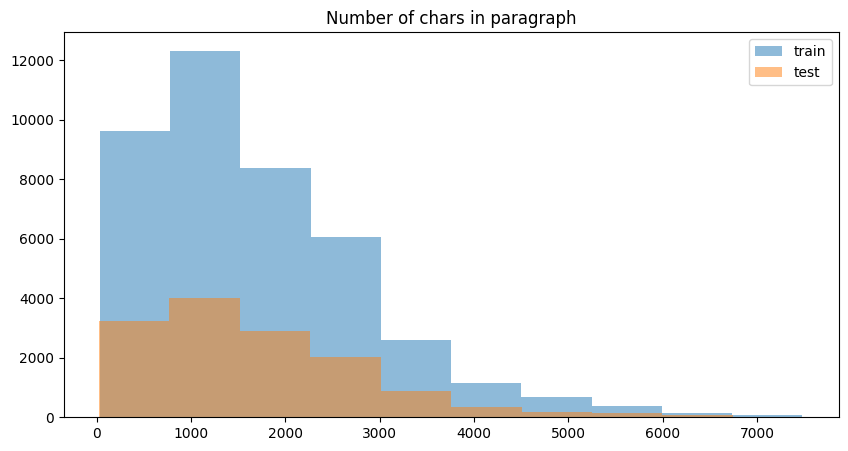

In [6]:
from collections import Counter
import matplotlib.pyplot as plt



train_sent_len = np.array(train_data.text.apply(lambda x: len(x)))
test_sent_len = np.array(test_data.text.apply(lambda x: len(x)))

plt.rcParams["figure.figsize"] = 10, 5
plt.hist(train_sent_len[np.where(train_sent_len < 7500)], alpha=0.5, label="train")
plt.hist(test_sent_len[np.where(test_sent_len < 7500)], alpha=0.5, label="test")
plt.legend(loc="upper right")
plt.title("Number of chars in paragraph")
plt.show()


In [7]:
import advertools as adv
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = []
for key in ["danish", "german", "dutch", "italian", "spanish"]:
    stop_words += list(adv.stopwords[key])


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm="l2", encoding="latin-1", ngram_range=(1, 2), stop_words=stop_words)

features = tfidf.fit_transform(train_data.text)
labels = train_data.category_id
features.shape


(41568, 150446)

In [8]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for dialect, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
  bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
  # trigrams = [v for v in feature_names if len(v.split(" ")) == 3]
  print("# '{}':".format(dialect))
  print("  . Most correlated unigrams:\n. {}".format("\n. ".join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format("\n. ".join(bigrams[-N:])))
  # print("  . Most correlated trigrams:\n. {}".format("\n. ".join(trigrams[-N:])))


# 'England':
  . Most correlated unigrams:
. irland
. irlanda
  . Most correlated bigrams:
. britiske konservative
. escrito votado
# 'Ireland':
  . Most correlated unigrams:
. irland
. irlanda
  . Most correlated bigrams:
. ierse regering
. gobierno irlandés
# 'Scotland':
  . Most correlated unigrams:
. schotland
. escocia
  . Most correlated bigrams:
. votado favor
. escrito votado


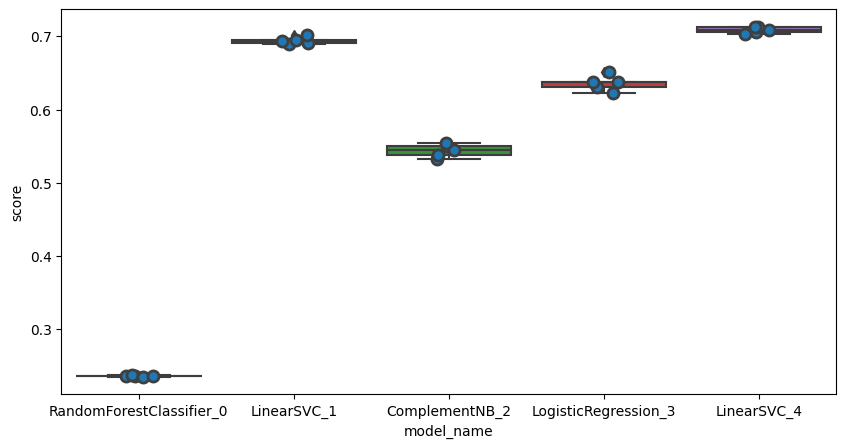

model_name
ComplementNB_2              0.543723
LinearSVC_1                 0.694275
LinearSVC_4                 0.708951
LogisticRegression_3        0.635935
RandomForestClassifier_0    0.235464
Name: score, dtype: float64


In [9]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(max_iter=5000),
    ComplementNB(),
    LogisticRegression(random_state=0, max_iter=5000),

    LinearSVC(max_iter=5000, random_state=21, C=1.5,  penalty="l1", dual=False, class_weight="balanced"),
    
]
kfold = KFold(n_splits=5, shuffle=True, random_state=69420)
entries = []
_scoring = make_scorer(f1_score, average="macro")

for i, model in enumerate(models):
  model_name = f"{model.__class__.__name__}_{i}"
  scores = cross_val_score(model, features, labels, scoring=_scoring, cv=kfold)
  for fold_idx, score in enumerate(scores):
    entries.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "score"])
sns.boxplot(x="model_name", y="score", data=cv_df)
sns.stripplot(x="model_name", y="score", data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
print(cv_df.groupby("model_name").score.mean())


In [44]:
model = LinearSVC()
params = {  "penalty": ["l1","l2"],
            "dual": [True, False],
            "max_iter": [6009],
            "C": [1,5],
            "loss": ['hinge', 'squared_hinge'],
            "multi_class": ["ovr", "crammer_singer"],
            "class_weight": ["balanced", None],
            "random_state": [21]
} 
clf = GridSearchCV(model, params, scoring=_scoring, cv=kfold, return_train_score=True, n_jobs=-1, verbose=2)
clf.fit(features, labels)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\lmg\AppData\Roaming\Python\Python310\site-packages\sklearn\svm\_base.py", line 1204, in 

GridSearchCV(cv=KFold(n_splits=5, random_state=69420, shuffle=True),
             estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [1, 5], 'class_weight': ['balanced', None],
                         'dual': [True, False],
                         'loss': ['hinge', 'squared_hinge'], 'max_iter': [6009],
                         'multi_class': ['ovr', 'crammer_singer'],
                         'penalty': ['l1', 'l2'], 'random_state': [21]},
             return_train_score=True,
             scoring=make_scorer(f1_score, average=macro), verbose=2)

In [45]:
clf.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'loss': 'squared_hinge',
 'max_iter': 6009,
 'multi_class': 'ovr',
 'penalty': 'l1',
 'random_state': 21}